# Clickbait Detection with Transformer Models

In this assignment, you will build and evaluate transformer-based models for detecting clickbait headlines. Clickbait refers to content with misleading or sensationalized headlines designed primarily to attract attention and encourage visitors to click on a link, often at the expense of accuracy or quality. Detecting clickbait automatically is an important NLP task with applications in content moderation and media literacy.


In [35]:
# note that in handin.py this step would need to be removed
# !pip install transformers datasets wandb
# !pip uninstall -y torchvision
# !pip install torchvision==0.21.0 --index-url https://download.pytorch.org/whl/cu126


In [36]:
# This code block has just standard setup code for running in Python

# Import PyTorch
import torch
from torch import nn
from torch.utils.data import DataLoader, random_split
import numpy as np
import matplotlib.pyplot as plt
import os
import json
import random
from transformers import AutoTokenizer, AutoModel
from datasets import load_dataset
from torch.optim import SGD, Adam, AdamW

# For experiment tracking
import wandb

# Fix the random seed for reproducability
torch.random.manual_seed(8942764)
torch.cuda.manual_seed(8942764)
np.random.seed(8942764)

In [37]:
# Please set your device by uncommenting the right version below

# On colab or on a machine with access to an Nvidia GPU  use the following setting
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# if you have an Apple Silicon machine with a GPU, use the following setting
# this should about 3-4 times faster that running it on a plain CPU
# device = 'mps' if torch.backends.mps.is_available() else 'cpu'

# If you will use a cpu, this is the setting
# device='cpu'

print(f"Using device: {device}")


Using device: cuda


## Utility Functions
These functions help with model setup, data processing, training, and evaluation.

You'll need to implement the parts marked with TODO comments.

In [38]:
# Function to load the dataset
def load_data(force_redownload=False):
    """
    Load the clickbait dataset from Hugging Face

    Returns:
        dataset: A dataset dictionary containing train, validation, and test splits
    """
    # TODO: Implement this function to load the dataset from Hugging Face
    # Use the load_dataset function to load the clickbait dataset
    # The dataset ID is "christinacdl/clickbait_notclickbait_dataset"
    extra_args = {}
    if force_redownload:
        extra_args['download_mode'] = "force_redownload"
    dataset = load_dataset("christinacdl/clickbait_notclickbait_dataset", **extra_args)
    return dataset


In [39]:
# Function to initialize and return instance of Autotokenizer with the given model name
def get_tokenizer(model_name):
    """
    Get the appropriate tokenizer for the given model name

    Args:
        model_name: Name of the pre-trained model (e.g., 'bert-base-uncased')

    Returns:
        tokenizer: The tokenizer for the specified model
    """
    # TODO: Implement this function
    # Load and return the pre-trained Autotokenizer for the specified model name
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    return tokenizer

In [40]:
# Tokenization function for data processing
def tokenize(batch, tokenizer):
    """
    Transform text data to tokenized format for model input

    Args:
        batch: Batch of examples from the dataset
        tokenizer: Tokenizer to use for encoding

    Returns:
        Dict with tokenized inputs and labels
    """
    sentences = [x['text'] for x in batch]
    labels = torch.LongTensor([x['label'] for x in batch])
    new_batch = dict(tokenizer(sentences, padding=True, truncation=True, return_tensors="pt"))
    new_batch['label'] = labels
    return new_batch

In [41]:
# Function to initialize wandb for experiment tracking
def init_wandb(config, project_name):
    """Initialize wandb with given config"""
    wandb.init(
        project=project_name,
        config=config
    )
    return wandb.config

In [42]:
# Training function
def train(model,
          train_dataset,
          val_dataset,
          num_epochs,
          batch_size,
          optimizer_cls,
          lr,
          weight_decay,
          device,
          tokenizer,
          use_wandb=False):
    """
    Train the model and track with wandb if specified

    Args:
        model: Model to train
        train_dataset: Training dataset
        val_dataset: Validation dataset
        num_epochs: Number of epochs to train for
        batch_size: Batch size for training
        optimizer_cls: Name of optimizer to use ('SGD', 'Adam', 'AdamW')
        lr: Learning rate
        weight_decay: Weight decay for regularization
        device: Device to train on
        tokenizer: Tokenizer for processing inputs
        use_wandb: Whether to log metrics to wandb

    Returns:
        Tuple of (trained model, training history)
    """
    # TODO: Set the model to training mode and move it to the specified device
    model.train()
    model.to(device)


    dataloader = DataLoader(train_dataset, batch_size, shuffle=True,
                          collate_fn=lambda batch: tokenize(batch, tokenizer))

    # TODO: Initialize the optimizers based on the optimizer_cls parameter, with the specified learning rates and weight decays.
    if optimizer_cls == 'SGD':
        optimizer = SGD(params=model.parameters(), lr=lr, weight_decay=weight_decay)
    elif optimizer_cls == 'Adam':
        optimizer = Adam(params=model.parameters(), lr=lr, weight_decay=weight_decay)
    elif optimizer_cls == 'AdamW':
        optimizer = AdamW(params=model.parameters(), lr=lr, weight_decay=weight_decay)

    train_loss_history = []
    train_acc_history = []
    val_loss_history = []
    val_acc_history = []

    lossfn = nn.CrossEntropyLoss()  # Using CrossEntropyLoss which expects logits

    global_step = 0

    for e in range(num_epochs):
        epoch_loss_history = []
        epoch_acc_history = []

        # Training loop
        model.train()
        for i, batch in enumerate(dataloader):
            batch = {k:v.to(device) for k,v in batch.items() if isinstance(v, torch.Tensor)}
            y = batch.pop('label')

            # TODO: Implement forward pass and loss computation
            # 1. Pass the batch through the model to get logits
            logits = model(**batch)
            # 2. Calculate the loss using lossfn
            ce_loss = lossfn(logits, y)

            # 3. Calculate the accuracy (percentage of correct predictions)
            predictions = torch.argmax(logits, dim=1)
            accuracy = (predictions == y).float().mean()
            # 4. Append each epoch's loss and accuracy to epoch_loss_history and epoch_acc_history
            epoch_loss_history.append(ce_loss.item())
            epoch_acc_history.append(accuracy.item())

            global_step += 1

            # Print every 100 steps
            if global_step % 100 == 0:
                print(f'Epoch: {e+1}, Step: {global_step}, Train Loss: {epoch_loss_history[-1]:.3e}, Train Accuracy: {epoch_acc_history[-1]:.3f}')

                # Log batch metrics to WandB
                if use_wandb:
                    wandb.log({
                        "global_step": global_step,  # Correct step tracking
                        "train_loss_step": epoch_loss_history[-1],  # Current batch loss
                        "train_accuracy_step": epoch_acc_history[-1],  # Current batch accuracy
                        "epoch": e + 1,
                    })

            # TODO: Implement backward pass and optimization step
            # 1. Zero the gradients
            optimizer.zero_grad()
            # 2. Backpropagate the loss
            ce_loss.backward()
            # 3. Update the model parameters using the optimizer
            optimizer.step()

        # Evaluation on validation set
        # TODO: Set the model to Evaluation mode
        model.eval()
        val_loss, val_acc, _, _, _ = evaluate(model, val_dataset, batch_size, device, tokenizer)

        train_loss_history.append(np.mean(epoch_loss_history))
        train_acc_history.append(np.mean(epoch_acc_history))
        val_loss_history.append(val_loss)
        val_acc_history.append(val_acc)

        print(f'epoch: {e + 1}\t train_loss: {train_loss_history[-1]:.3e}\t train_accuracy:{train_acc_history[-1]:.3f}\t val_loss: {val_loss_history[-1]:.3e}\t val_accuracy:{val_acc_history[-1]:.3f}')

        # Log metrics to wandb if enabled
        if use_wandb:
            wandb.log({
                "epoch": e + 1,
                "train_loss": train_loss_history[-1],
                "train_accuracy": train_acc_history[-1],
                "val_loss": val_loss_history[-1],
                "val_accuracy": val_acc_history[-1]
            })

    return model, (train_loss_history, train_acc_history, val_loss_history, val_acc_history)


In [43]:
# Evaluation function
@torch.no_grad()
def evaluate(model, dataset, batch_size, device, tokenizer):
    """
    Evaluate model on dataset

    Args:
        model: Model to evaluate
        dataset: Dataset to evaluate on
        batch_size: Batch size for evaluation
        device: Device to run evaluation on
        tokenizer: Tokenizer for processing inputs

    Returns:
        Tuple of (loss, accuracy, predictions, labels, logits)
    """
    # TODO: Set the model to evaluation mode and move it to the specified device
    model.eval()
    model.to(device)


    dataloader = DataLoader(dataset, batch_size, shuffle=False,
                           collate_fn=lambda batch: tokenize(batch, tokenizer))
    lossfn = nn.CrossEntropyLoss()  # Using CrossEntropyLoss which expects logits

    loss_history = []
    acc_history = []
    all_preds = []
    all_labels = []
    all_logits = []

    for i, batch in enumerate(dataloader):
        batch = {k:v.to(device) for k,v in batch.items() if isinstance(v, torch.Tensor)}
        y = batch.pop('label')

        # TODO: Implement the evaluation loop
        # Loop through batches in the dataloader
        # 1. Get model predictions by passing in the batch (logits)
        logits = model(**batch)
        # 2. Calculate loss
        loss = lossfn(logits, y)
        # 3. Get the predictions from the logits in the variable pred
        pred = torch.argmax(logits, dim=1)


        acc = (pred == y).float().mean()

        all_preds.extend(pred.cpu().numpy())
        all_labels.extend(y.cpu().numpy())
        all_logits.extend(logits.cpu().numpy())

        loss_history.append(loss.item())
        acc_history.append(acc.item())

    # TODO: Calculate and return the evaluation metrics
    # Return the mean loss, mean accuracy, all predictions, all labels, and all logits
    mean_loss = np.mean(loss_history)
    mean_accuracy = np.mean(acc_history)
    return mean_loss, mean_accuracy, all_preds, all_labels, all_logits
    pass


In [44]:
# Function to load a test set and generate predictions
def predict_on_test_set(model, tokenizer, test_file_path, output_file_path, device):
    """
    Generate predictions on a test set and save to file

    Args:
        model: Trained model
        tokenizer: Tokenizer for the model
        test_file_path: Path to the test data file
        output_file_path: Path to save predictions
        device: Device to run inference on
    """
    # Load test data
    with open(test_file_path, 'r') as f:
        test_data = json.load(f)

    print(f"Loaded {len(test_data)} examples from {test_file_path}")

    # Make predictions
    # TODO: Set the model to evaluation mode
    model.eval()

    # TODO: Initialize an empty list to store predictions
    predictions = []

    for item in test_data:
        # TODO: Tokenize the text and move to the correct device as variable inputs
        inputs = tokenizer(item['text'], return_tensors='pt', padding=True, truncation=True)
        inputs = {k: v.to(device) for k, v in inputs.items()}

        # Get predictions
        # TODO: Disable gradient propagation
        with torch.no_grad():
        # TODO: Pass the inputs to the model to get logits
            logits = model(**inputs)
        # TODO: Get the prediction from logits
            pred = torch.argmax(logits, dim=1).item()

        # Store prediction as a string (0 or 1)
        predictions.append(str(pred))

    # Write predictions to file - one prediction per line
    with open(output_file_path, 'w') as f:
        f.write('\n'.join(predictions))

    print(f"Predictions saved to {output_file_path}")

## Model Architecture
This section defines the model architecture for transformer-based text classification.


In [45]:
# Base Transformer Model class for text classification
class TransformerForTextClassification(nn.Module):
    def __init__(self, model_name, num_classes, freeze_base=False, hidden_size=128, num_layers=1):
        """
        Transformer model with a classification head

        Args:
            model_name: Name of the base transformer model (e.g., 'bert-base-uncased')
            num_classes: Number of output classes
            freeze_base: Whether to freeze the base model parameters
            hidden_size: Size of the hidden layers in the classifier
            num_layers: Number of hidden layers in the classifier
        """
        super().__init__()

        self.base_model = AutoModel.from_pretrained(model_name) # TODO: Load pre-trained model using AutoModel.from_pretrained

        # Freeze base model if specified
        self.base_model.requires_grad_(not freeze_base)

        if not freeze_base:
            self.unfreeze_top_k_layers(5)

        # Get the hidden size from the base model config
        base_hidden_size = self.base_model.config.hidden_size

        # Build classifier with variable number of hidden layers
        if num_layers == 1:
            self.classifier = nn.Sequential(
                # TODO: Build classifier with variable number of hidden layers
                # For num_layers=1, create a classifier with:
                #   - Linear layer from base_hidden_size to hidden_size
                nn.Linear(base_hidden_size, hidden_size),
                #   - ReLU activation
                nn.ReLU(),
                #   - Linear layer from hidden_size to num_classes
                nn.Linear(hidden_size, num_classes)
            )
        elif num_layers == 2:
            self.classifier = nn.Sequential(
                # TODO: For num_layers=2, add an additional hidden layer
                nn.Linear(base_hidden_size, hidden_size),
                nn.ReLU(),
                nn.Linear(hidden_size, hidden_size),
                nn.ReLU(),
                nn.Linear(hidden_size, num_classes)
            )
        elif num_layers == 3:
            self.classifier = nn.Sequential(
                # TODO: For num_layers=3, add two additional hidden layers
                nn.Linear(base_hidden_size, hidden_size),
                nn.ReLU(),
                nn.Linear(hidden_size, hidden_size),
                nn.ReLU(),
                nn.Linear(hidden_size, hidden_size),
                nn.ReLU(),
                nn.Linear(hidden_size, num_classes)
            )
        else:
            raise ValueError(f"Unsupported number of layers: {num_layers}")

    def unfreeze_top_k_layers(self, k=5):
        """
        Unfreezes the top k layers of a Transformer model (BERT or ModernBERT).

        Parameters:
            model: The Transformer model (e.g., BERT or ModernBERT).
            k: Number of top layers to unfreeze (default is 5).
        """
        # TODO: First, freeze all layers in the base model
        for param in self.base_model.parameters():
            param.requires_grad = False

        # Detect whether the model uses standard BERT or ModernBERT
        if hasattr(self.base_model, "encoder"):  # Standard BERT
            layers = self.base_model.encoder.layer
        elif hasattr(self.base_model, "layers"):  # ModernBERT
            layers = self.base_model.layers
        else:
            raise ValueError("Unrecognized model architecture: Cannot find encoder layers.")

        # Get the total number of layers
        total_layers = len(layers) # TODO

        # Unfreeze the last k layers
        for i in range(total_layers - k, total_layers):
            for param in layers[i].parameters():
                # TODO: Unfreeze this layer
                param.requires_grad = True

        print(f"Unfroze the last {k} layers out of {total_layers} total layers.")

    def forward(self, **base_model_kwargs):
        """Forward pass through the model"""
        outputs = self.base_model(**base_model_kwargs)
        # Use the pooled output for classification
        pooled_output = outputs.last_hidden_state[:, 0, :] # TODO: Extract the [CLS] token embedding from the last hidden state
        # Return logits (not probabilities)
        logits = self.classifier(pooled_output) # TODO: Pass the pooled output through the classifier to get logits
        return logits

In [46]:
# Function to create model with specified architecture
def get_model(model_name, num_classes, freeze_base=False, hidden_size=128, num_layers=1):
    """Create model with specified architecture"""
    return TransformerForTextClassification(
        model_name=model_name,
        num_classes=num_classes,
        freeze_base=freeze_base,
        hidden_size=hidden_size,
        num_layers=num_layers
    )

### Dataset
We'll be using a dataset of headlines labeled as either clickbait (1) or not clickbait (0). The dataset comes from Hugging Face and includes training, validation, and test splits. You'll have an opportunity to explore the data distribution and characteristics before building your models.


In [47]:
# Load dataset
dataset = load_data()
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['label', 'text'],
        num_rows: 43802
    })
    validation: Dataset({
        features: ['label', 'text'],
        num_rows: 2191
    })
    test: Dataset({
        features: ['label', 'text'],
        num_rows: 8760
    })
})


In [48]:
# Look at some examples
print("\nExamples from training set:")
for i in range(3):
    print(f"Example {i}: {dataset['train'][i]}")

print("\nExamples from validation set:")
for i in range(3):
    print(f"Example {i}: {dataset['validation'][i]}")


Examples from training set:
Example 0: {'label': 0, 'text': 'Alphabet Scraps Plan to Blanket Globe With Internet Balloons'}
Example 1: {'label': 0, 'text': 'US Boy Scouts and hikers airlifted from wildfire in Utah'}
Example 2: {'label': 1, 'text': "Here's What Happened When I Road Tripped Around Southern California For A Week"}

Examples from validation set:
Example 0: {'label': 1, 'text': '27 Happy Gifts For People Who Love Jamaica'}
Example 1: {'label': 1, 'text': 'How Adulthood Happens '}
Example 2: {'label': 0, 'text': 'President Donald Trump Has Historically Low Approval Ratings As He Nears 100-Day Mark'}


In [49]:
# Look at class distribution
train_labels = [example['label'] for example in dataset['train']]
val_labels = [example['label'] for example in dataset['validation']]
test_labels = [example['label'] for example in dataset['test']]

print("\nClass distribution:")
print(f"Training set: Clickbait: {train_labels.count(1)}, Not clickbait: {train_labels.count(0)}")
print(f"Validation set: Clickbait: {val_labels.count(1)}, Not clickbait: {val_labels.count(0)}")
print(f"Test set: Clickbait: {test_labels.count(1)}, Not clickbait: {test_labels.count(0)}")



Class distribution:
Training set: Clickbait: 16257, Not clickbait: 27545
Validation set: Clickbait: 813, Not clickbait: 1378
Test set: Clickbait: 3252, Not clickbait: 5508


## Explore tokenization

In [50]:
# Explore tokenization
bert_tokenizer = get_tokenizer("bert-base-uncased")
modernbert_tokenizer = get_tokenizer("answerdotai/ModernBERT-base")

In [51]:
print("\nTokenization examples:")
example_text = dataset['train'][8]['text']
print(f"Original text: '{example_text}'")
print(f"BERT tokenization: {bert_tokenizer.tokenize(example_text)}")
print(f"ModernBERT tokenization: {modernbert_tokenizer.tokenize(example_text)}")


Tokenization examples:
Original text: '15 Things You Never Noticed About Owning A Cat'
BERT tokenization: ['15', 'things', 'you', 'never', 'noticed', 'about', 'owning', 'a', 'cat']
ModernBERT tokenization: ['15', 'ĠThings', 'ĠYou', 'ĠNever', 'ĠNot', 'iced', 'ĠAbout', 'ĠOw', 'ning', 'ĠA', 'ĠCat']


## Task 1: Model Selection

In this task, you will compare the performance of two different transformer architectures for the clickbait detection task:

1. **BERT (bert-base-uncased)**: A widely-used transformer model developed by Google that has been pre-trained on a large corpus of English text.

2. **ModernBERT (answerdotai/ModernBERT-base)**: A more recent transformer variant that has been trained on newer text data and may have better performance on contemporary language patterns.

You'll train and evaluate both models with the same baseline configuration to determine which architecture provides a stronger foundation for our clickbait detection system.

This comparison will help us understand:
- Which model better captures the linguistic patterns characteristic of clickbait
- Whether the newer ModernBERT has advantages over the classic BERT architecture for this specific application

After completing this task, you'll select the better-performing model to use as the foundation for further refinement in Task 2.

In [52]:
def run_model_selection():
    """Run model selection task comparing BERT and RoBERTa"""

    # Define models to compare
    model_configs = [
        {
            "name": "bert-base-uncased",
            "display_name": "BERT",
            "freeze_base": True
        },
        {
            "name": "answerdotai/ModernBERT-base",
            "display_name": "ModernBERT",
            "freeze_base": True
        }
    ]

    # Training parameters
    train_params = {
        "num_epochs": 3,
        "batch_size": 32,
        "optimizer_cls": "Adam",
        "lr": 1e-3,
        "weight_decay": 1e-4,
        "hidden_size": 128,
        "num_layers": 1
    }

    results = []

    for config in model_configs:
        model_name = config["name"]
        display_name = config["display_name"]
        print(f"\n{'='*50}")
        print(f"Training and evaluating {display_name} model")
        print(f"{'='*50}")

        tokenizer = get_tokenizer(model_name) # TODO: Initialize the tokenizer for the selected model using the get_tokenizer function defined before

        # Initialize wandb
        wandb_config = {**config, **train_params}
        #init_wandb(wandb_config, "clickbait-detection-task1")
        wandb.init(
            project="clickbait-detection-task1",
            config=wandb_config,
            name=f'{display_name}'
        )

        # Create model
        model = get_model(
            model_name=model_name,
            num_classes=2,
            freeze_base=config["freeze_base"],
            hidden_size=train_params["hidden_size"],
            num_layers=train_params["num_layers"]
        )

        # TODO: Print the number of trainable parameters in the model
        num_params = sum(p.numel() for p in model.parameters() if p.requires_grad) # TODO
        print(f"Model trainable parameters: {num_params}")

        # Train model
        model, logs = train(
            model=model,
            train_dataset=dataset['train'],
            val_dataset=dataset['validation'],
            num_epochs=train_params["num_epochs"],
            batch_size=train_params["batch_size"],
            optimizer_cls=train_params["optimizer_cls"],
            lr=train_params["lr"],
            weight_decay=train_params["weight_decay"],
            device=device,
            tokenizer=tokenizer,
            use_wandb=True
        )

        # Evaluate on validation set
        val_loss, val_acc, _, _, _ = evaluate(
            model=model,
            dataset=dataset['validation'],
            batch_size=train_params["batch_size"],
            device=device,
            tokenizer=tokenizer
        )

        # Record results
        results.append({
            "model_name": model_name,
            "display_name": display_name,
            "val_accuracy": val_acc,
            "val_loss": val_loss,
            "logs": logs,
            "model": model,
            "tokenizer": tokenizer
        })

        wandb.finish()

    # Compare results
    print("\nModel Selection Results:")
    print(f"{'Model':<10} {'Validation Accuracy':<20} {'Validation Loss':<15}")
    print("-" * 45)

    for result in results:
        print(f"{result['display_name']:<10} {result['val_accuracy']:.4f}{' '*15} {result['val_loss']:.4f}")

    return results


In [ ]:
# Run model selection
task1_results = run_model_selection()


Training and evaluating BERT model


wandb: Currently logged in as: jgibson02 (jgibson02-carnegie-mellon-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


2025-11-14 19:58:18.527732: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1763150298.543708   20260 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763150298.548655   20260 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-11-14 19:58:18.566161: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model trainable parameters: 98690
Epoch: 1, Step: 100, Train Loss: 3.352e-01, Train Accuracy: 0.812
Epoch: 1, Step: 200, Train Loss: 2.447e-01, Train Accuracy: 0.938
Epoch: 1, Step: 300, Train Loss: 3.003e-01, Train Accuracy: 0.938
Epoch: 1, Step: 400, Train Loss: 2.165e-01, Train Accuracy: 0.906
Epoch: 1, Step: 500, Train Loss: 2.041e-01, Train Accuracy: 0.969
Epoch: 1, Step: 600, Train Loss: 4.029e-01, Train Accuracy: 0.781
Epoch: 1, Step: 700, Train Loss: 2.777e-01, Train Accuracy: 0.938
Epoch: 1, Step: 800, Train Loss: 2.130e-01, Train Accuracy: 0.938
Epoch: 1, Step: 900, Train Loss: 2.628e-01, Train Accuracy: 0.906
Epoch: 1, Step: 1000, Train Loss: 1.523e-01, Train Accuracy: 0.906
Epoch: 1, Step: 1100, Train Loss: 1.701e-01, Train Accuracy: 0.906
Epoch: 1, Step: 1200, Train Loss: 2.796e-01, Train Accuracy: 0.906
Epoch: 1, Step: 1300, Train Loss: 2.947e-01, Train Accuracy: 0.875
epoch: 1	 train_loss: 2.934e-01	 train_accuracy:0.882	 val_loss: 2.858e-01	 val_accuracy:0.895
Epoch: 2,

epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▅▅▅▅▅▅▅▅▅▅▅▅▅▅█████████████
global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
train_accuracy,▁▆█
train_accuracy_step,▂▇▇▆█▁▇▇▆▆▆▆▅▆▃▇▆▅▁▇▇▆▅▅▅▆▆█▇▇▆▆▇█▇▆▃▆▃▂
train_loss,█▃▁
train_loss_step,▄▃▃▂▂▅▃▂▃▁▁▃▃▂▄▃▂▂█▂▁▃▅▄▅▃▂▁▁▂▃▅▂▁▂▂▃▂▄▄
val_accuracy,▁█▁
val_loss,█▁▂
epoch,3
global_step,4100
train_accuracy,0.896



Training and evaluating ModernBERT model


Model trainable parameters: 98690
Epoch: 1, Step: 100, Train Loss: 6.223e-01, Train Accuracy: 0.750
Epoch: 1, Step: 200, Train Loss: 5.656e-01, Train Accuracy: 0.719
Epoch: 1, Step: 300, Train Loss: 1.991e-01, Train Accuracy: 0.969
Epoch: 1, Step: 400, Train Loss: 3.309e-01, Train Accuracy: 0.875
Epoch: 1, Step: 500, Train Loss: 2.957e-01, Train Accuracy: 0.844
Epoch: 1, Step: 600, Train Loss: 2.619e-01, Train Accuracy: 0.844
Epoch: 1, Step: 700, Train Loss: 3.088e-01, Train Accuracy: 0.906
Epoch: 1, Step: 800, Train Loss: 1.563e-01, Train Accuracy: 0.938
Epoch: 1, Step: 900, Train Loss: 4.829e-01, Train Accuracy: 0.781
Epoch: 1, Step: 1000, Train Loss: 5.057e-01, Train Accuracy: 0.750
Epoch: 1, Step: 1100, Train Loss: 1.778e-01, Train Accuracy: 0.938
Epoch: 1, Step: 1200, Train Loss: 1.137e-01, Train Accuracy: 0.969
Epoch: 1, Step: 1300, Train Loss: 1.397e-01, Train Accuracy: 0.969
epoch: 1	 train_loss: 2.984e-01	 train_accuracy:0.881	 val_loss: 2.753e-01	 val_accuracy:0.889
Epoch: 2,

epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▅▅▅▅▅▅▅▅▅▅▅▅▅▅█████████████
global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
train_accuracy,▁▇█
train_accuracy_step,▂▁▇▅▄▄▆▆▃▂▆▇▇▃▃▆▅▆█▄▆▃▃█▆▆▆▇▆▆▆▃▆▃▅█▆▄▄▄
train_loss,█▂▁
train_loss_step,█▇▃▄▄▄▄▂▆▇▃▂▂▇▆▄▃▃▁▆▃▄▅▂▃▄▃▂▃▂▄▄▃▆▇▁▂▄▆▄
val_accuracy,▁▇█
val_loss,█▂▁
epoch,3
global_step,4100
train_accuracy,0.90103



Model Selection Results:
Model      Validation Accuracy  Validation Loss
---------------------------------------------
BERT       0.8953                0.2701
ModernBERT 0.9026                0.2501



Training and evaluating BERT model


ConnectionResetError: Connection lost

In [ ]:
# TODO: Get the best model from Task 1 results
# 1. Find the model with the highest validation accuracy in task1_results
# 2. Extract the model, model_name, and tokenizer from the best result
# 3. Print information about which model will be used for further tasks
best_model_result = max(task1_results, key=lambda x: x['val_accuracy']) # TODO
best_model = best_model_result['model'] # TODO
best_model_name = best_model_result['model_name'] # TODO
best_tokenizer = best_model_result['tokenizer'] #TODO

print(f"\nBest model from Task 1: {best_model_name}")
print(f"Using {best_model_name} for further tasks")


Best model from Task 1: answerdotai/ModernBERT-base
Using answerdotai/ModernBERT-base for further tasks


## Task 2: Hyperparameter Tuning

Now that we have selected the best model architecture, let's tune its hyperparameters to optimize performance.

In this task, you'll experiment with different hyperparameter configurations to find the best model. You should explore variations in:

- **Hidden layer sizes**: Try different sizes for the hidden layers in your classifier (e.g., 64, 128, 256, 512)
- **Number of hidden layers**: Experiment with adding more layers to your classifier (e.g., 1, 2, 3 layers)
- **Batch sizes**: Test different batch sizes (e.g., 16, 32, 64) - note that larger batch sizes may cause memory issues
- **Learning rates**: Try different learning rates (e.g., 1e-3, 5e-4, 1e-4)
- **Freezing base parameters**: Experiment with keeping the whole base model frozen vs unfreezing just the top 5 layers of the base model.
- **Optimizer**: You can try different optimizers like Adam, AdamW, or SGD

You should run at least 5 different hyperparameter configurations and track their performance using wandb. Below is a template for setting up your experiments.


In [ ]:
# Define your hyperparameter configurations to test
# You should define at least 5 different configurations to explore the hyperparameter space
hp_configs = [
    # Configuration 1 (baseline)
    {
        "config_name": "Baseline",
        "hidden_size": 128,
        "num_layers": 1,
        "batch_size": 32,
        "optimizer": "Adam",
        "learning_rate": 1e-3,
        "weight_decay": 1e-4,
        "freeze_base": True,
        "num_epochs": 5
    },

    # # Configuration 2 - MODIFY THIS!
    {
        "config_name": "Config 2",
        "hidden_size": 512,
        "num_layers": 2,
        "batch_size": 64,
        "optimizer": "AdamW",
        "freeze_base": False,
        "learning_rate": 1e-4,
        "weight_decay": 1e-4,  # Do NOT change
        "num_epochs": 5        # Do NOT change
    },

    # # Configuration 3 - MODIFY THIS!
    {
        "config_name": "Config 3",
        "hidden_size": 512,
        "num_layers": 3,
        "batch_size": 32,
        "optimizer": "AdamW",
        "freeze_base": False,
        "learning_rate": 1e-5,
        "weight_decay": 1e-4,  # Do NOT change
        "num_epochs": 5        # Do NOT change
    },

    # # Configuration 4 - MODIFY THIS!
    {
        "config_name": "Config 4",
        "hidden_size": 64,
        "num_layers": 2,
        "batch_size": 32,
        "optimizer": "Adam",
        "freeze_base": True,
        "learning_rate": 3e-3,
        "weight_decay": 1e-4,  # Do NOT change
        "num_epochs": 5        # Do NOT change
    },

    # # Configuration 5 - MODIFY THIS!
    {
        "config_name": "Config 5",
        "hidden_size": 512,
        "num_layers": 3,
        "batch_size": 16,
        "optimizer": "SGD",
        "freeze_base": False,
        "learning_rate": 5e-4,
        "weight_decay": 1e-4,  # Do NOT change
        "num_epochs": 5        # Do NOT change
    },
    # Add more configurations if you want to explore more thoroughly!
]


In [ ]:
def run_hyperparameter_tuning(model_name, base_tokenizer):
    """
    Run hyperparameter tuning experiments

    Args:
        model_name: Name of the model to use
        base_tokenizer: Tokenizer for the model

    Returns:
        List of experiment results
    """
    print(f"\n{'='*50}")
    print(f"Running Hyperparameter Tuning for {model_name}")
    print(f"{'='*50}")

    results = []
    best_val_acc = 0
    best_config_idx = 0
    best_model = None

    # For each configuration in your hp_configs list
    for i, config in enumerate(hp_configs):
        print(f"\nRunning experiment {i+1}/{len(hp_configs)}: {config['config_name']}")

        # Initialize wandb for this experiment
        wandb_config = {**config, "model_name": model_name}
        #init_wandb(wandb_config, "clickbait-detection-task2")
        wandb.init(
            project="clickbait-detection-task1",
            config=wandb_config,
            name=config["config_name"]
        )

        # Create model with this configuration
        model = get_model(
            model_name=model_name,
            num_classes=2,
            freeze_base=config["freeze_base"],
            hidden_size=config["hidden_size"],
            num_layers=config["num_layers"]
        )

        # Train model
        model, logs = train(
            model=model,
            train_dataset=dataset['train'],
            val_dataset=dataset['validation'],
            num_epochs=config["num_epochs"],
            batch_size=config["batch_size"],
            optimizer_cls=config["optimizer"],
            lr=config["learning_rate"],
            weight_decay=config["weight_decay"],
            device=device,
            tokenizer=base_tokenizer,
            use_wandb=True
        )

        # Evaluate on validation set
        val_loss, val_acc, _, _, _ = evaluate(
            model=model,
            dataset=dataset['validation'],
            batch_size=config["batch_size"],
            device=device,
            tokenizer=base_tokenizer
        )

        # Log final validation metrics
        wandb.log({
            "final_val_loss": val_loss,
            "final_val_accuracy": val_acc
        })

        # Finish wandb run
        wandb.finish()

        # Record results
        results.append({
            "config_name": config["config_name"],
            "hidden_size": config["hidden_size"],
            "num_layers": config["num_layers"],
            "batch_size": config["batch_size"],
            "learning_rate": config["learning_rate"],
            "weight_decay": config["weight_decay"],
            "optimizer": config["optimizer"],
            "val_loss": val_loss,
            "val_accuracy": val_acc,
            "model": model
        })

        # Keep track of best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_config_idx = i
            best_model = model

    # Display results in a table
    print("\nHyperparameter Tuning Results:")
    print("-" * 120)
    print(f"{'Config':<10} {'Hidden Size':<12} {'Layers':<8} {'Batch Size':<12} {'Learning Rate':<14} {'Weight Decay':<14} {'Optimizer':<10} {'Val Accuracy':<15}")
    print("-" * 120)

    for result in results:
        print(f"{result['config_name']:<10} {result['hidden_size']:<12} {result['num_layers']:<8} {result['batch_size']:<12} {result['learning_rate']:<14} {result['weight_decay']:<14} {result['optimizer']:<10} {result['val_accuracy']:.4f}")

    print("-" * 120)
    print(f"Best configuration: {results[best_config_idx]['config_name']} with validation accuracy: {best_val_acc:.4f}")

    return results, best_model, best_config_idx

In [ ]:
# Run Task 2: Hyperparameter Tuning
# Run all hyperparameter experiments
tuning_results, best_tuned_model, best_config_idx = run_hyperparameter_tuning(best_model_name, best_tokenizer)



Running Hyperparameter Tuning for answerdotai/ModernBERT-base

Running experiment 1/5: Baseline


Epoch: 1, Step: 100, Train Loss: 4.093e-01, Train Accuracy: 0.844
Epoch: 1, Step: 200, Train Loss: 2.605e-01, Train Accuracy: 0.875
Epoch: 1, Step: 300, Train Loss: 3.405e-01, Train Accuracy: 0.875
Epoch: 1, Step: 400, Train Loss: 2.676e-01, Train Accuracy: 0.938
Epoch: 1, Step: 500, Train Loss: 1.754e-01, Train Accuracy: 0.969
Epoch: 1, Step: 600, Train Loss: 2.132e-01, Train Accuracy: 0.906
Epoch: 1, Step: 700, Train Loss: 1.651e-01, Train Accuracy: 0.969
Epoch: 1, Step: 800, Train Loss: 2.097e-01, Train Accuracy: 0.938
Epoch: 1, Step: 900, Train Loss: 3.068e-01, Train Accuracy: 0.844
Epoch: 1, Step: 1000, Train Loss: 3.309e-01, Train Accuracy: 0.906
Epoch: 1, Step: 1100, Train Loss: 1.637e-01, Train Accuracy: 0.969
Epoch: 1, Step: 1200, Train Loss: 3.358e-01, Train Accuracy: 0.875
Epoch: 1, Step: 1300, Train Loss: 2.791e-01, Train Accuracy: 0.906
epoch: 1	 train_loss: 2.993e-01	 train_accuracy:0.882	 val_loss: 2.729e-01	 val_accuracy:0.891
Epoch: 2, Step: 1400, Train Loss: 3.147e-01

epoch,▁▁▁▁▁▁▁▁▁▃▃▃▃▃▃▃▃▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆████████
final_val_accuracy,▁
final_val_loss,▁
global_step,▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇███
train_accuracy,▁▅▇▇█
train_accuracy_step,▄▅▅▆▇▄▅▇▅▅▇▇▅▅▅▆▅▅▄▇▅▁▅▅▆▅▅▅▄█▆▇▆▆▅▅▄▅▇▆
train_loss,█▄▂▂▁
train_loss_step,▆▅▃▂▂▄▂▅▄▂▆▃▁▅█▃▃▃▂▁▆▂▃▅▄▃█▂▁▂▃▄▂▂▅▄▁▃▂▃
val_accuracy,▁█▇█▅
val_loss,█▁▁▁▅
epoch,5



Running experiment 2/5: Config 2


Unfroze the last 5 layers out of 22 total layers.
Epoch: 1, Step: 100, Train Loss: 2.967e-01, Train Accuracy: 0.891
Epoch: 1, Step: 200, Train Loss: 2.369e-01, Train Accuracy: 0.922
Epoch: 1, Step: 300, Train Loss: 2.759e-01, Train Accuracy: 0.938
Epoch: 1, Step: 400, Train Loss: 1.683e-01, Train Accuracy: 0.953
Epoch: 1, Step: 500, Train Loss: 1.911e-01, Train Accuracy: 0.922
Epoch: 1, Step: 600, Train Loss: 2.838e-01, Train Accuracy: 0.891
epoch: 1	 train_loss: 2.430e-01	 train_accuracy:0.906	 val_loss: 2.319e-01	 val_accuracy:0.906
Epoch: 2, Step: 700, Train Loss: 1.732e-01, Train Accuracy: 0.938
Epoch: 2, Step: 800, Train Loss: 1.688e-01, Train Accuracy: 0.922
Epoch: 2, Step: 900, Train Loss: 1.367e-01, Train Accuracy: 0.953
Epoch: 2, Step: 1000, Train Loss: 2.706e-01, Train Accuracy: 0.922
Epoch: 2, Step: 1100, Train Loss: 2.311e-01, Train Accuracy: 0.906
Epoch: 2, Step: 1200, Train Loss: 1.624e-01, Train Accuracy: 0.922
Epoch: 2, Step: 1300, Train Loss: 7.829e-02, Train Accuracy:

epoch,▁▁▁▁▁▁▁▃▃▃▃▃▃▃▃▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆████████
final_val_accuracy,▁
final_val_loss,▁
global_step,▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇███
train_accuracy,▁▃▅██
train_accuracy_step,▁▃▄▅▃▁▄▃▅▃▂▃▇▅▆▆▇▅▆▅█▇▇█▇▇██▇███▇█
train_loss,█▆▄▁▁
train_loss_step,█▇█▅▅█▅▅▄▇▆▅▃▄▃▃▂▃▂▃▁▂▂▁▂▂▂▁▂▁▁▁▂▁
val_accuracy,▂▇▁██
val_loss,▁▁▃▇█
epoch,5



Running experiment 3/5: Config 3


Unfroze the last 5 layers out of 22 total layers.
Epoch: 1, Step: 100, Train Loss: 3.041e-01, Train Accuracy: 0.938
Epoch: 1, Step: 200, Train Loss: 1.944e-01, Train Accuracy: 0.969
Epoch: 1, Step: 300, Train Loss: 2.266e-01, Train Accuracy: 0.906
Epoch: 1, Step: 400, Train Loss: 2.019e-01, Train Accuracy: 0.906
Epoch: 1, Step: 500, Train Loss: 2.593e-01, Train Accuracy: 0.875
Epoch: 1, Step: 600, Train Loss: 3.200e-01, Train Accuracy: 0.875
Epoch: 1, Step: 700, Train Loss: 1.809e-01, Train Accuracy: 0.938
Epoch: 1, Step: 800, Train Loss: 2.432e-01, Train Accuracy: 0.938
Epoch: 1, Step: 900, Train Loss: 1.334e-01, Train Accuracy: 0.938
Epoch: 1, Step: 1000, Train Loss: 2.718e-01, Train Accuracy: 0.906
Epoch: 1, Step: 1100, Train Loss: 1.577e-01, Train Accuracy: 1.000
Epoch: 1, Step: 1200, Train Loss: 3.225e-01, Train Accuracy: 0.875
Epoch: 1, Step: 1300, Train Loss: 2.359e-01, Train Accuracy: 0.906
epoch: 1	 train_loss: 2.896e-01	 train_accuracy:0.886	 val_loss: 2.522e-01	 val_accuracy

epoch,▁▁▁▁▁▁▁▁▃▃▃▃▃▃▃▃▃▃▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆██████
final_val_accuracy,▁
final_val_loss,▁
global_step,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇███
train_accuracy,▁▄▅▆█
train_accuracy_step,▆▅▃▃▆▅█▃▅▂▇▂▆▇▇▁▃▂▆█▆▆▂▃▅█▇▆▂▂▆▅▇▇█▆▆▅▇█
train_loss,█▅▄▃▁
train_loss_step,▄▅▄▅▄▃▆▄▅▃▃▆▃▄▃█▂▄▄▆▂▃▄█▇▃▃▂▁▃▃▃▃▅▂▁▄▄▂▁
val_accuracy,▁▄▄▆█
val_loss,▄▂▁▂█
epoch,5



Running experiment 4/5: Config 4


Epoch: 1, Step: 100, Train Loss: 3.692e-01, Train Accuracy: 0.844
Epoch: 1, Step: 200, Train Loss: 3.322e-01, Train Accuracy: 0.812
Epoch: 1, Step: 300, Train Loss: 4.260e-01, Train Accuracy: 0.781
Epoch: 1, Step: 400, Train Loss: 1.554e-01, Train Accuracy: 0.969
Epoch: 1, Step: 500, Train Loss: 2.581e-01, Train Accuracy: 0.906
Epoch: 1, Step: 600, Train Loss: 1.817e-01, Train Accuracy: 0.906
Epoch: 1, Step: 700, Train Loss: 1.377e-01, Train Accuracy: 0.938
Epoch: 1, Step: 800, Train Loss: 8.309e-02, Train Accuracy: 0.969
Epoch: 1, Step: 900, Train Loss: 3.246e-01, Train Accuracy: 0.906
Epoch: 1, Step: 1000, Train Loss: 3.506e-01, Train Accuracy: 0.875
Epoch: 1, Step: 1100, Train Loss: 1.354e-01, Train Accuracy: 0.969
Epoch: 1, Step: 1200, Train Loss: 2.052e-01, Train Accuracy: 0.969
Epoch: 1, Step: 1300, Train Loss: 1.498e-01, Train Accuracy: 0.938
epoch: 1	 train_loss: 3.002e-01	 train_accuracy:0.883	 val_loss: 2.780e-01	 val_accuracy:0.887
Epoch: 2, Step: 1400, Train Loss: 3.225e-01

epoch,▁▁▁▁▁▁▃▃▃▃▃▃▃▃▃▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆█████████
final_val_accuracy,▁
final_val_loss,▁
global_step,▁▁▁▁▂▂▂▂▂▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇███
train_accuracy,▁▆▇▇█
train_accuracy_step,▃█▆▇███▇▅▃▆▇▁▇▅▆▅▅▆▇▃▆▃▇▃█▃▇▆▇█▃▆▅▅▆▇▇█▅
train_loss,█▃▂▂▁
train_loss_step,▇▆█▂▃▆▆▂▆▁▅▃▅▆█▂▃▄▃▄▃▂▆▄▇▂▇▃▂▄▂▄▂▄▆▄▂▅▅█
val_accuracy,▁▆█▇▆
val_loss,█▄▁▂▂
epoch,5



Running experiment 5/5: Config 5


Unfroze the last 5 layers out of 22 total layers.
Epoch: 1, Step: 100, Train Loss: 6.611e-01, Train Accuracy: 0.750
Epoch: 1, Step: 200, Train Loss: 6.516e-01, Train Accuracy: 0.688
Epoch: 1, Step: 300, Train Loss: 6.644e-01, Train Accuracy: 0.625
Epoch: 1, Step: 400, Train Loss: 6.900e-01, Train Accuracy: 0.562
Epoch: 1, Step: 500, Train Loss: 6.306e-01, Train Accuracy: 0.688
Epoch: 1, Step: 600, Train Loss: 6.806e-01, Train Accuracy: 0.562
Epoch: 1, Step: 700, Train Loss: 5.804e-01, Train Accuracy: 0.812
Epoch: 1, Step: 800, Train Loss: 7.212e-01, Train Accuracy: 0.438
Epoch: 1, Step: 900, Train Loss: 5.710e-01, Train Accuracy: 0.812
Epoch: 1, Step: 1000, Train Loss: 7.515e-01, Train Accuracy: 0.375
Epoch: 1, Step: 1100, Train Loss: 6.642e-01, Train Accuracy: 0.562
Epoch: 1, Step: 1200, Train Loss: 6.852e-01, Train Accuracy: 0.500
Epoch: 1, Step: 1300, Train Loss: 7.254e-01, Train Accuracy: 0.438
Epoch: 1, Step: 1400, Train Loss: 5.678e-01, Train Accuracy: 0.750
Epoch: 1, Step: 1500,

epoch,▁▁▁▁▁▁▃▃▃▃▃▃▃▃▃▃▃▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆████████
final_val_accuracy,▁
final_val_loss,▁
global_step,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
train_accuracy,▁▇███
train_accuracy_step,▅▁▆▃▄▄▃▃▆▅▆▆▆▆▄█▆▆▇▅▆█▆▆▇▇▆▇▆█▇▆▆▆▆▆▆██▆
train_loss,█▄▂▁▁
train_loss_step,███▇█▇▇▇█▆▅▇▆█▄▂▃▂▁▂▃▁▂▃▄▃▂▂▁▆▅▂▅▂▄▃▁▂▁▄
val_accuracy,▁▇▇██
val_loss,█▃▂▁▁
epoch,5



Hyperparameter Tuning Results:
------------------------------------------------------------------------------------------------------------------------
Config     Hidden Size  Layers   Batch Size   Learning Rate  Weight Decay   Optimizer  Val Accuracy   
------------------------------------------------------------------------------------------------------------------------
Baseline   128          1        32           0.001          0.0001         Adam       0.8976
Config 2   512          2        64           0.0001         0.0001         AdamW      0.9124
Config 3   512          3        32           1e-05          0.0001         AdamW      0.9130
Config 4   64           2        32           0.003          0.0001         Adam       0.8981
Config 5   512          3        16           0.0005         0.0001         SGD        0.8841
------------------------------------------------------------------------------------------------------------------------
Best configuration: Config 3 wit

## Task 3: Final Evaluation and Error Analysis

In this task, we'll:
1. Train the best model configuration from Task 2 on the combined training and validation data
2. Evaluate this final model on the test set
3. Generate predictions for the provided held-out test set
4. Perform detailed error analysis to understand the model's strengths and weaknesses

In [ ]:
# First, train your best model from Task 2
# Replace these parameters with those from your best configuration in Task 2
best_config = {
    "hidden_size": 512,    # Replace with your best value
    "num_layers": 3,       # Replace with your best value
    "batch_size": 32,      # Replace with your best value
    "optimizer": "AdamW",   # Replace with your best value
    "learning_rate": 1e-5, # Replace with your best value
    "weight_decay": 1e-4,
    "freeze_base": False,    # Replace with your best value
    "num_epochs": 5
}

In [ ]:
print("\nTraining final model with best configuration...")
final_model = get_model(
    model_name=best_model_name,
    num_classes=2,
    freeze_base=best_config["freeze_base"],
    hidden_size=best_config["hidden_size"],
    num_layers=best_config["num_layers"]
)


Training final model with best configuration...
Unfroze the last 5 layers out of 22 total layers.


In [ ]:
final_model, _ = train(
    model=final_model,
    train_dataset=dataset['train'],
    val_dataset=dataset['validation'],
    num_epochs=best_config["num_epochs"],
    batch_size=best_config["batch_size"],
    optimizer_cls=best_config["optimizer"],
    lr=best_config["learning_rate"],
    weight_decay=best_config["weight_decay"],
    device=device,
    tokenizer=best_tokenizer,
    use_wandb=False
)

Epoch: 1, Step: 100, Train Loss: 3.110e-01, Train Accuracy: 0.938
Epoch: 1, Step: 200, Train Loss: 3.521e-01, Train Accuracy: 0.812
Epoch: 1, Step: 300, Train Loss: 2.389e-01, Train Accuracy: 0.906
Epoch: 1, Step: 400, Train Loss: 1.777e-01, Train Accuracy: 0.969
Epoch: 1, Step: 500, Train Loss: 4.037e-01, Train Accuracy: 0.812
Epoch: 1, Step: 600, Train Loss: 1.921e-01, Train Accuracy: 0.938
Epoch: 1, Step: 700, Train Loss: 6.289e-01, Train Accuracy: 0.688
Epoch: 1, Step: 800, Train Loss: 2.201e-01, Train Accuracy: 0.906
Epoch: 1, Step: 900, Train Loss: 2.037e-01, Train Accuracy: 0.906
Epoch: 1, Step: 1000, Train Loss: 1.794e-01, Train Accuracy: 0.969
Epoch: 1, Step: 1100, Train Loss: 2.409e-01, Train Accuracy: 0.812
Epoch: 1, Step: 1200, Train Loss: 3.605e-01, Train Accuracy: 0.875
Epoch: 1, Step: 1300, Train Loss: 2.700e-01, Train Accuracy: 0.844
epoch: 1	 train_loss: 2.955e-01	 train_accuracy:0.884	 val_loss: 2.512e-01	 val_accuracy:0.903
Epoch: 2, Step: 1400, Train Loss: 1.662e-01

In [ ]:
print("\nEvaluating final model on test set...")
test_loss, test_acc, test_preds, test_labels, test_logits = evaluate(
    final_model,
    dataset['test'],
    batch_size=32,
    device=device,
    tokenizer=best_tokenizer
)

print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")



Evaluating final model on test set...


Test Accuracy: 0.9012
Test Loss: 0.2839


In [ ]:
test_file_path = 'second-test-data-DIST.json'
if os.path.exists(test_file_path):
    predict_on_test_set(
        model=final_model,
        tokenizer=best_tokenizer,
        test_file_path=test_file_path,
        output_file_path='test-results.txt',
        device=device
    )

    if os.path.exists('test-results.txt'):
        with open('test-results.txt', 'r') as f:
            predictions = f.read().strip().split('\n')
        print(f"SUCCESS: Created test-results.txt with {len(predictions)} predictions")
        print(f"Sample predictions (first 5): {predictions[:5] if len(predictions) >= 5 else predictions}")
    else:
        print("ERROR: Failed to create test-results.txt. Please check for errors.")
else:
    print(f"\nERROR: Test file {test_file_path} not found!")

Loaded 882 examples from second-test-data-DIST.json


Predictions saved to test-results.txt
SUCCESS: Created test-results.txt with 882 predictions
Sample predictions (first 5): ['0', '1', '1', '1', '1']


## Error Analysis


In [ ]:
# TODO: Look at individual examples in the valid split of the dataset
print("\nAnalyzing individual examples from the validation set:")
for i in range(5):
    example = dataset['validation'][i]
    text = example['text']
    label = example['label']
    print(f"\nExample {i+1}:")
    print(f"Text: {text}")
    print(f"True Label: {'Clickbait' if label == 1 else 'Not Clickbait'}")

    # Tokenize the example
    inputs = best_tokenizer(text, return_tensors='pt', padding=True, truncation=True)
    inputs = {k: v.to(device) for k, v in inputs.items()}

    # Get model prediction
    with torch.no_grad():
        logits = final_model(**inputs)
        pred_label = torch.argmax(logits, dim=1).item()
        pred_prob = torch.softmax(logits, dim=1)[0][pred_label].item()

    print(f"Predicted Label: {'Clickbait' if pred_label == 1 else 'Not Clickbait'} (Confidence: {pred_prob:.4f})")


Analyzing individual examples from the validation set:

Example 1:
Text: 27 Happy Gifts For People Who Love Jamaica
True Label: Clickbait
Predicted Label: Clickbait (Confidence: 0.9995)

Example 2:
Text: How Adulthood Happens 
True Label: Clickbait
Predicted Label: Not Clickbait (Confidence: 0.8501)

Example 3:
Text: President Donald Trump Has Historically Low Approval Ratings As He Nears 100-Day Mark
True Label: Not Clickbait
Predicted Label: Not Clickbait (Confidence: 0.7826)

Example 4:
Text: High-level Defence meetings with Japan postponed over Minister Marise Payne's health
True Label: Not Clickbait
Predicted Label: Not Clickbait (Confidence: 0.9997)

Example 5:
Text: Cheney meets with Israeli and Palestinian leaders
True Label: Not Clickbait
Predicted Label: Not Clickbait (Confidence: 0.9999)


## Submission Instructions

When you're ready to submit your assignment, please follow these steps:

1. Submit this completed ipynb **without clearing any output cells**, renamed as `hw3.ipynb`
   - Make sure your code can load the best model configuration
   - Include necessary functions for tokenization, prediction, etc.
   - Make sure it can run the test predictions on `test-DIST.json`

2. Download `test-results.txt` this notebook generated with your predictions on the provided test set. Perform a manual check to see if:
   - Each line should contain a single character: '1' for clickbait or '0' for non-clickbait
   - No other content should be in this file

3. Read and complete the hw3 report (report.pdf). It has the following sections:
   - Part 1: Model Selection
     - Compare BERT vs ModernBERT performance
     - Explain your choice of model and why it performed better
     - Discuss any observations about tokenization differences
   
   - Part 2: Hyperparameter Tuning
     - Table with all configurations tested and their results
     - Analysis of how different hyperparameters affected performance
     - Include and explain wandb plots
     - Justify your final model configuration

Submit the following files to Gradescope:
- `hw3.ipynb`: Your code implementation
- `test-results.txt`: Predictions on the test set
- `report.pdf`: Your detailed report

Make sure your name and Andrew ID are on the first page of your report.

# Error Analysis

In [ ]:
# Additional imports for error analysis
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import f1_score, classification_report, confusion_matrix
import pandas as pd
import seaborn as sns
import re
from collections import Counter

### Predictions on the Validation Set

Validation Accuracy: 0.9039
Validation F1-Score: 0.9032

Detailed Classification Report:
               precision    recall  f1-score   support

Not Clickbait     0.9124    0.9369    0.9245      1378
    Clickbait     0.8879    0.8475    0.8672       813

     accuracy                         0.9037      2191
    macro avg     0.9001    0.8922    0.8958      2191
 weighted avg     0.9033    0.9037    0.9032      2191



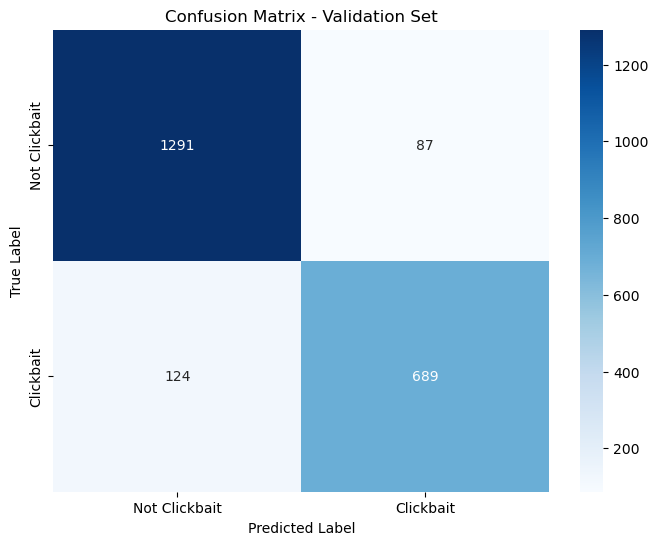


Confidence Statistics:
Mean confidence: 0.9398
Std confidence: 0.1071
Min confidence: 0.5000
Max confidence: 1.0000

Error Distribution:
error_type
Correct           1980
False Negative     124
False Positive      87
Name: count, dtype: int64
Total validation examples: 2191


/tmp/ipykernel_20260/3443040683.py:31: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  val_probs = torch.softmax(torch.tensor(val_logits), dim=1).numpy()


In [ ]:
val_loss, val_acc, val_preds, val_labels, val_logits = evaluate(
    final_model,
    dataset['validation'],
    batch_size=32,
    device=device,
    tokenizer=best_tokenizer
)

# F1 score and other metrics
val_f1 = f1_score(val_labels, val_preds, average='weighted')
print(f"Validation Accuracy: {val_acc:.4f}")
print(f"Validation F1-Score: {val_f1:.4f}")

# Create detailed classification report
print("\nDetailed Classification Report:")
report = classification_report(val_labels, val_preds, target_names=['Not Clickbait', 'Clickbait'], digits=4)
print(report)

# Confusion Matrix
cm = confusion_matrix(val_labels, val_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Not Clickbait', 'Clickbait'], 
            yticklabels=['Not Clickbait', 'Clickbait'])
plt.title('Confusion Matrix - Validation Set')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Confidence scores
val_probs = torch.softmax(torch.tensor(val_logits), dim=1).numpy()
val_confidence = np.max(val_probs, axis=1)

print(f"\nConfidence Statistics:")
print(f"Mean confidence: {np.mean(val_confidence):.4f}")
print(f"Std confidence: {np.std(val_confidence):.4f}")
print(f"Min confidence: {np.min(val_confidence):.4f}")
print(f"Max confidence: {np.max(val_confidence):.4f}")

# Create analysis dataframe
analysis_df = pd.DataFrame({
    'text': [dataset['validation'][i]['text'] for i in range(len(val_labels))],
    'true_label': val_labels,
    'predicted_label': val_preds,
    'confidence': val_confidence,
    'correct': np.array(val_labels) == np.array(val_preds)
})

analysis_df['error_type'] = 'Correct'
analysis_df.loc[(analysis_df['true_label'] == 0) & (analysis_df['predicted_label'] == 1), 'error_type'] = 'False Positive'
analysis_df.loc[(analysis_df['true_label'] == 1) & (analysis_df['predicted_label'] == 0), 'error_type'] = 'False Negative'

print(f"\nError Distribution:")
print(analysis_df['error_type'].value_counts())
print(f"Total validation examples: {len(analysis_df)}")

### Linguistic Analysis

In [ ]:
def analyze_text_features(text):
    """Extract linguistic features from text for analysis"""
    features = {}
    
    # Basic text statistics
    features['length'] = len(text)
    features['word_count'] = len(text.split())
    features['sentence_count'] = len(re.split(r'[.!?]+', text))
    features['avg_word_length'] = np.mean([len(word) for word in text.split()])
    
    # Punctuation analysis
    features['exclamation_marks'] = text.count('!')
    features['question_marks'] = text.count('?')
    features['ellipsis'] = text.count('...')
    features['quotation_marks'] = text.count('"') + text.count("'")
    features['capital_letters'] = sum(1 for c in text if c.isupper())
    features['capital_ratio'] = features['capital_letters'] / len(text) if len(text) > 0 else 0
    
    # Clickbait indicators
    clickbait_words = ['amazing', 'shocking', 'incredible', 'unbelievable', 'secret', 'revealed', 
                       'you won\'t believe', 'this will', 'what happens next', 'number', 'reasons',
                       'tricks', 'tips', 'ways', 'things', 'facts', 'shocking', 'surprising']
    features['clickbait_words'] = sum(1 for word in clickbait_words if word.lower() in text.lower())
    
    # Emotional words
    emotional_words = ['love', 'hate', 'amazing', 'terrible', 'awesome', 'horrible', 'fantastic', 
                       'awful', 'incredible', 'shocking', 'stunning', 'devastating']
    features['emotional_words'] = sum(1 for word in emotional_words if word.lower() in text.lower())
    
    # Numbers and quantities
    features['contains_numbers'] = bool(re.search(r'\d', text))
    features['number_count'] = len(re.findall(r'\d+', text))
    
    return features

features_list = [analyze_text_features(text) for text in analysis_df['text']]
features_df = pd.DataFrame(features_list)

analysis_df = pd.concat([analysis_df.reset_index(drop=True), features_df.reset_index(drop=True)], axis=1)

ANALYZING FALSE POSITIVES
Total False Positives: 87

False Positive Rate: 3.97%

TOP 10 MOST CONFIDENT FALSE POSITIVES:

1. CONFIDENCE: 0.9999
   TEXT: How To Beat The DEATH GAME In Funhouse
   FEATURES: 8 words, 0 excl, 0 clickbait words

2. CONFIDENCE: 0.9992
   TEXT: 7 Dinners Under $10 You Should Make This Week
   FEATURES: 9 words, 0 excl, 0 clickbait words

3. CONFIDENCE: 0.9990
   TEXT: BANKS On What Happens When You Give Your Fans Your Phone Number
   FEATURES: 12 words, 0 excl, 1 clickbait words

4. CONFIDENCE: 0.9990
   TEXT: This Artist Will Teach You How To Draw Using "The Penis Method"
   FEATURES: 12 words, 0 excl, 0 clickbait words

5. CONFIDENCE: 0.9984
   TEXT: Here Are The 2017 Grammy Nominations
   FEATURES: 6 words, 0 excl, 0 clickbait words

6. CONFIDENCE: 0.9984
   TEXT: Jaime Lannister Almost Spoiled A Major "Game Of Thrones" Plot Point And I Kinda Wish He Had
   FEATURES: 17 words, 0 excl, 0 clickbait words

7. CONFIDENCE: 0.9978
   TEXT: Watch This Guy Dynamite

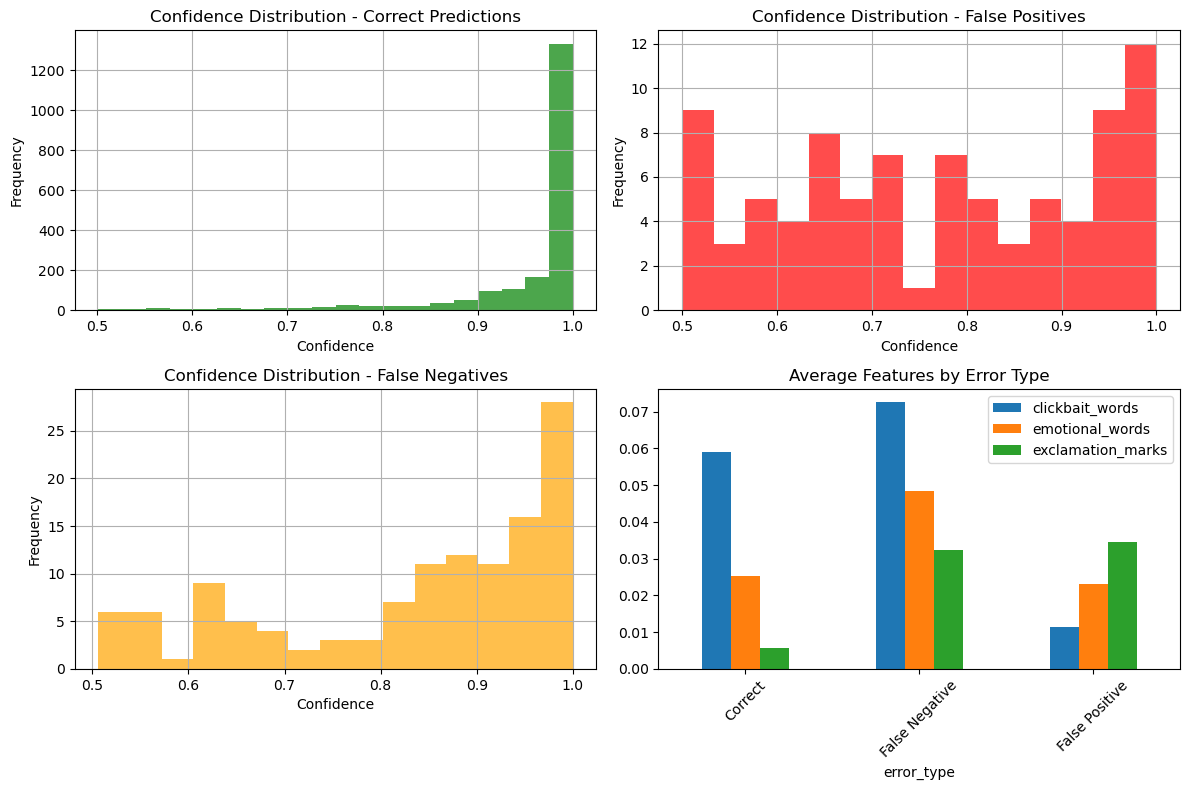

In [ ]:
# Analysis: False Positives
print("="*60)
print("ANALYZING FALSE POSITIVES")
print("="*60)

false_positives = analysis_df[analysis_df['error_type'] == 'False Positive'].copy()
print(f"Total False Positives: {len(false_positives)}")

if len(false_positives) > 0:
    print(f"\nFalse Positive Rate: {len(false_positives) / len(analysis_df) * 100:.2f}%")
    
    # Sort by confidence to see most confident mistakes
    false_positives_sorted = false_positives.sort_values('confidence', ascending=False)
    
    print("\n" + "="*50)
    print("TOP 10 MOST CONFIDENT FALSE POSITIVES:")
    print("="*50)
    
    for i, (idx, row) in enumerate(false_positives_sorted.head(10).iterrows()):
        print(f"\n{i+1}. CONFIDENCE: {row['confidence']:.4f}")
        print(f"   TEXT: {row['text']}")
        print(f"   FEATURES: {row['word_count']} words, {row['exclamation_marks']} excl, {row['clickbait_words']} clickbait words")
    
    # Statistical analysis of false positives
    print("\n" + "="*40)
    print("FALSE POSITIVE CHARACTERISTICS:")
    print("="*40)
    
    feature_cols = ['length', 'word_count', 'exclamation_marks', 'question_marks', 
                   'clickbait_words', 'emotional_words', 'capital_ratio', 'number_count']
    
    for feature in feature_cols:
        fp_mean = false_positives[feature].mean()
        overall_mean = analysis_df[feature].mean()
        print(f"{feature}: FP={fp_mean:.3f}, Overall={overall_mean:.3f}, Diff={fp_mean-overall_mean:.3f}")

print("\n" + "="*60)
print("ANALYZING FALSE NEGATIVES")
print("="*60)

false_negatives = analysis_df[analysis_df['error_type'] == 'False Negative'].copy()
print(f"Total False Negatives: {len(false_negatives)}")

if len(false_negatives) > 0:
    print(f"\nFalse Negative Rate: {len(false_negatives) / len(analysis_df) * 100:.2f}%")
    
    # Sort by confidence to see most confident mistakes
    false_negatives_sorted = false_negatives.sort_values('confidence', ascending=False)
    
    print("\n" + "="*50)
    print("TOP 10 MOST CONFIDENT FALSE NEGATIVES:")
    print("="*50)
    
    for i, (idx, row) in enumerate(false_negatives_sorted.head(10).iterrows()):
        print(f"\n{i+1}. CONFIDENCE: {row['confidence']:.4f}")
        print(f"   TEXT: {row['text']}")
        print(f"   FEATURES: {row['word_count']} words, {row['exclamation_marks']} excl, {row['clickbait_words']} clickbait words")
    
    # Statistical analysis of false negatives
    print("\n" + "="*40)
    print("FALSE NEGATIVE CHARACTERISTICS:")
    print("="*40)
    
    for feature in feature_cols:
        fn_mean = false_negatives[feature].mean()
        overall_mean = analysis_df[feature].mean()
        print(f"{feature}: FN={fn_mean:.3f}, Overall={overall_mean:.3f}, Diff={fn_mean-overall_mean:.3f}")

# Pattern Analysis
print("\n" + "="*60)
print("PATTERN ANALYSIS")
print("="*60)

# Most common words in false positives vs false negatives
def get_word_patterns(texts):
    all_words = []
    for text in texts:
        words = re.findall(r'\b\w+\b', text.lower())
        all_words.extend(words)
    return Counter(all_words)

if len(false_positives) > 0:
    fp_words = get_word_patterns(false_positives['text'])
    print(f"\nMost common words in FALSE POSITIVES:")
    for word, count in fp_words.most_common(15):
        print(f"  {word}: {count}")

if len(false_negatives) > 0:
    fn_words = get_word_patterns(false_negatives['text'])
    print(f"\nMost common words in FALSE NEGATIVES:")
    for word, count in fn_words.most_common(15):
        print(f"  {word}: {count}")

# Confidence distribution by error type
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
analysis_df[analysis_df['error_type'] == 'Correct']['confidence'].hist(bins=20, alpha=0.7, color='green', label='Correct')
plt.title('Confidence Distribution - Correct Predictions')
plt.xlabel('Confidence')
plt.ylabel('Frequency')

plt.subplot(2, 2, 2)
if len(false_positives) > 0:
    false_positives['confidence'].hist(bins=15, alpha=0.7, color='red', label='False Positive')
plt.title('Confidence Distribution - False Positives')
plt.xlabel('Confidence')
plt.ylabel('Frequency')

plt.subplot(2, 2, 3)
if len(false_negatives) > 0:
    false_negatives['confidence'].hist(bins=15, alpha=0.7, color='orange', label='False Negative')
plt.title('Confidence Distribution - False Negatives')
plt.xlabel('Confidence')
plt.ylabel('Frequency')

plt.subplot(2, 2, 4)
# Feature correlation with errors
error_features = analysis_df.groupby('error_type')[['clickbait_words', 'emotional_words', 'exclamation_marks']].mean()
error_features.plot(kind='bar', ax=plt.gca())
plt.title('Average Features by Error Type')
plt.xticks(rotation=45)
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Advanced Analysis: Attention and Feature Importance
print("="*60)
print("ADVANCED ANALYSIS: LINGUISTIC PATTERNS")
print("="*60)

# Analyze by text length
print("\nAnalysis by Text Length:")
analysis_df['length_category'] = pd.cut(analysis_df['length'], 
                                       bins=[0, 50, 100, 150, float('inf')], 
                                       labels=['Short (<50)', 'Medium (50-100)', 'Long (100-150)', 'Very Long (>150)'])

length_analysis = analysis_df.groupby('length_category').agg({
    'correct': 'mean',
    'confidence': 'mean',
    'clickbait_words': 'mean',
    'emotional_words': 'mean'
}).round(4)

print(length_analysis)

# Analyze by clickbait word density
print("\n" + "="*50)
print("CLICKBAIT WORD DENSITY ANALYSIS:")
print("="*50)

analysis_df['clickbait_density'] = analysis_df['clickbait_words'] / analysis_df['word_count']
analysis_df['clickbait_density'] = analysis_df['clickbait_density'].fillna(0)

density_analysis = analysis_df.groupby('error_type').agg({
    'clickbait_density': ['mean', 'std', 'count'],
    'emotional_words': 'mean',
    'capital_ratio': 'mean',
    'exclamation_marks': 'mean'
}).round(4)

print(density_analysis)

# Find examples with high clickbait density but misclassified
print("\n" + "="*50)
print("HIGH CLICKBAIT DENSITY MISCLASSIFICATIONS:")
print("="*50)

high_density_errors = analysis_df[
    (analysis_df['clickbait_density'] > 0.1) & 
    (analysis_df['error_type'] != 'Correct')
].sort_values('clickbait_density', ascending=False)

for i, (idx, row) in enumerate(high_density_errors.head(5).iterrows()):
    print(f"\n{i+1}. ERROR TYPE: {row['error_type']}")
    print(f"   CLICKBAIT DENSITY: {row['clickbait_density']:.3f}")
    print(f"   TEXT: {row['text']}")
    print(f"   TRUE LABEL: {'Clickbait' if row['true_label'] == 1 else 'Not Clickbait'}")
    print(f"   PREDICTED: {'Clickbait' if row['predicted_label'] == 1 else 'Not Clickbait'}")

# Analyze specific phrase patterns
print("\n" + "="*50)
print("SPECIFIC PHRASE PATTERN ANALYSIS:")
print("="*50)

# Define suspicious patterns
patterns = {
    'question_starters': [r'^(what|how|why|when|where|which|who)', r'(what|how|why) (is|are|do|does|will|can)'],
    'listicle_patterns': [r'\d+ (ways|things|reasons|tips|tricks|facts)', r'(top|best) \d+'],
    'urgency_patterns': [r'(now|today|right now|immediately)', r'(don\'t|do not) (miss|wait)'],
    'emotional_hooks': [r'(shocking|amazing|incredible|unbelievable)', r'you (won\'t|will not) believe'],
    'direct_address': [r'you (need|should|must|have to)', r'(here\'s|this is) what']
}

for pattern_type, regex_list in patterns.items():
    print(f"\n{pattern_type.upper()}:")
    for pattern in regex_list:
        matches = analysis_df[analysis_df['text'].str.contains(pattern, case=False, na=False, regex=True)]
        if len(matches) > 0:
            error_rate = 1 - matches['correct'].mean()
            print(f"  Pattern '{pattern}': {len(matches)} matches, {error_rate:.3f} error rate")
            
            # Show some examples
            errors = matches[matches['correct'] == False]
            if len(errors) > 0:
                print(f"    Example error: {errors.iloc[0]['text'][:100]}...")

# Correlation analysis between features and model performance
print("\n" + "="*50)
print("FEATURE CORRELATION WITH MODEL PERFORMANCE:")
print("="*50)

numeric_features = ['length', 'word_count', 'exclamation_marks', 'question_marks', 
                   'clickbait_words', 'emotional_words', 'capital_ratio', 'number_count', 'confidence']

correlation_matrix = analysis_df[numeric_features + ['correct']].corr()['correct'].sort_values(ascending=False)
print("Correlation with correct predictions:")
for feature, corr in correlation_matrix.items():
    if feature != 'correct':
        print(f"  {feature}: {corr:.4f}")

print(f"\nTotal analysis completed on {len(analysis_df)} validation examples.")
print(f"Model achieved {analysis_df['correct'].mean():.4f} accuracy on validation set.")

ADVANCED ANALYSIS: LINGUISTIC PATTERNS

Analysis by Text Length:
                  correct  confidence  clickbait_words  emotional_words
length_category                                                        
Short (<50)        0.9291      0.9503           0.0374           0.0160
Medium (50-100)    0.8951      0.9377           0.0677           0.0299
Long (100-150)     0.8070      0.8924           0.0702           0.0526
Very Long (>150)   0.7692      0.7691           0.1538           0.1538

CLICKBAIT WORD DENSITY ANALYSIS:
               clickbait_density               emotional_words capital_ratio  \
                            mean     std count            mean          mean   
error_type                                                                     
Correct                   0.0058  0.0255  1980          0.0253        0.1222   
False Negative            0.0064  0.0270   124          0.0484        0.1277   
False Positive            0.0010  0.0089    87          0.0230       

/tmp/ipykernel_20260/1803870586.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  length_analysis = analysis_df.groupby('length_category').agg({
/tmp/ipykernel_20260/1803870586.py:72: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  matches = analysis_df[analysis_df['text'].str.contains(pattern, case=False, na=False, regex=True)]
